# Updated version (ver.1.2)

- ver.1

> step 1. Find the position of defects

> step 2. Enumerate separated regions

> step 3. Calculate SEMU of defects on different region

- ver.1.2

> step 1. Find both white Mura and black Mura

> step 2. Enumerate separated regions

> step 3. Calculate SEMU (background brightness is different for each defect, considering regional difference)


## 1. Find both white Mura and black Mura

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

enter image name: w (2)


(256, 256)

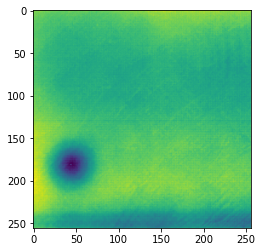

In [227]:
x = input('enter image name: ')

fname = f'./mura images/{x}.bmp'
# fname = "/home/cov/Desktop/PML/project1_Mura/AUO_Data/JND_RAW_DATA/C5A02VC/C5A02VC_C3_2_PM_HM_FMura.tif"
img = cv2.imread(fname, 0)
imgFloat = img.astype('float')# =np.float32(img)
coeff = cv2.dct(imgFloat)
coeff[:,3:]=0
coeff[3:][:]=0
reconsImg = cv2.idct(coeff)
diff = reconsImg-img
plt.imshow(diff)
img.shape

0


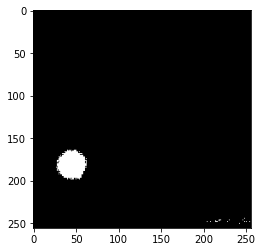

In [230]:
diff_n = cv2.normalize(diff, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC1)
thresh1 = cv2.adaptiveThreshold(diff_n, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,65, 50)# obtain white Mura
thresh2 = cv2.adaptiveThreshold(diff_n, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 65,-50)# obtain black Mura
BothT = thresh1+thresh2
plt.imshow(BothT, cmap='gray', vmin=0, vmax=255)
print(BothT[20,20])

(256, 256)

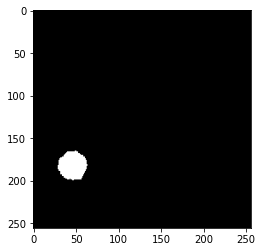

In [232]:
BothT2 = cv2.medianBlur(BothT, 3)
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(BothT2, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap='gray', vmin=0, vmax=255)
opening.shape

## 2. Enumerate separated regions

No.0 defect:


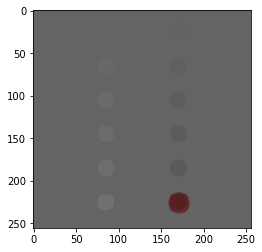

No.1 defect:


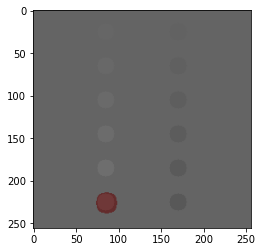

No.2 defect:


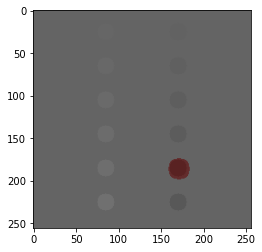

No.3 defect:


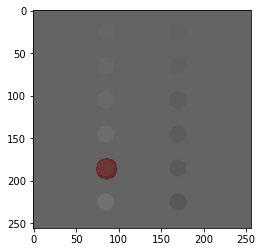

No.4 defect:


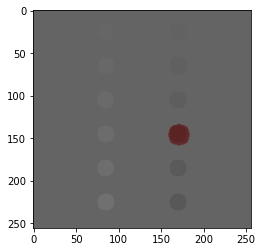

No.5 defect:


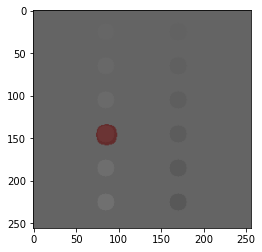

No.6 defect:


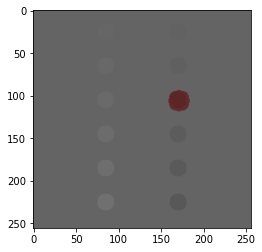

No.7 defect:


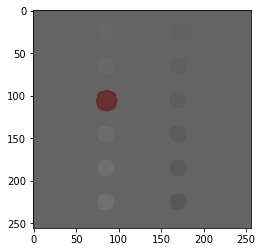

No.8 defect:


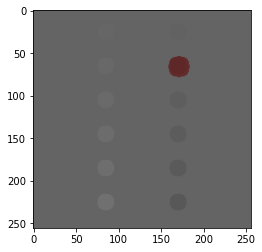

No.9 defect:


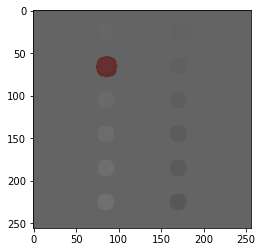

No.10 defect:


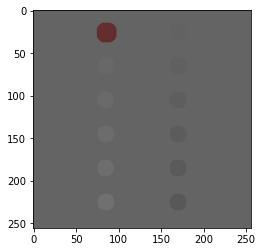

No.11 defect:


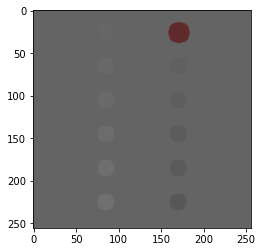

No.12 defect:


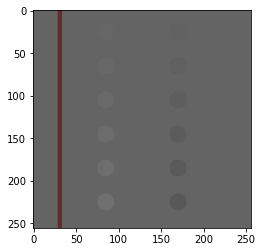

In [222]:
color = (255,200,200)#(200,200,200)
lst_dfcts = []
lst_bdbox = []
bdRect = []

_, opening2 = cv2.threshold(opening, 127, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(opening2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
for i in range(len(contours)):
    cimg,cimg2 = np.zeros_like(opening), np.zeros_like(opening)
    cv2.drawContours(cimg, contours, i, color, -1, cv2.LINE_8)
    pts = np.where(cimg == 255)
    lst_dfcts.append(img[pts[0], pts[1]]) # record the intensity at the defect pixels
    bdRect.append(cv2.boundingRect(contours[i]))
    cv2.rectangle(cimg2, (int(bdRect[i][0]), int(bdRect[i][1])),\
                  (int(bdRect[i][0]+bdRect[i][2]), int(bdRect[i][1]+bdRect[i][3])), 255, -1)
    pts2 = np.where(cimg2 == 255)
    lst_bdbox.append(img[pts2[0], pts2[1]])
    
for j in range(len(lst_dfcts)):
    drawing2 = np.zeros((opening.shape[0], opening.shape[1], 3), dtype=np.uint8)
    cv2.drawContours(drawing2, contours, j, color, -1, cv2.LINE_8)#, hierarchy, 0) # -1 doesn't count the boundary
    for i in range(3): # overlay
        drawing2[:,:,i] = drawing2[:,:,i]+img
    
    print("No.{} defect:".format(j))
    plt.imshow(drawing2)
    plt.show()

# 3. Calculate SEMU
## Calculate regional background intensity

Create a bounding box around the defect, the residual region is 

![How to calculate background intensity](a1.png)

- Yumi et.al did an experiment, and conclude that the JND contrast, $C_{jnd}$, can be expressed as $$C_{jnd}=\frac{1.97}{S^{0.33}}+0.72$$ (result of linear regression), where $S$ is the number of pixels of the defects.
Contrast value below $C_{jnd}$ can be viewed as no defect.

SEMI further defined the severity of a Mura defect. $$SEMU = \frac{|C_x|}{C_{jnd}}$$ where $|C_x|=\dfrac{|I_O-I_{Background}|}{I_{Background}}\times 100\%$ is the average contrast

In [225]:
I_Back = []
for i in range(len(lst_dfcts)):
    I_Back.append((sum(lst_bdbox[i])-sum(lst_dfcts[i]))/(len(lst_bdbox[i])-len(lst_dfcts[i])))

C_i = []
C_jnd_i = []
Semu_i = []

for i in range(len(lst_dfcts)):
    C_i.append(abs(I_Back[i]-sum(lst_dfcts[i])/len(lst_dfcts[i]))/I_Back[i]*100)
    C_jnd_i.append(1.97/(len(lst_dfcts[i])**0.33) + 0.72)
    Semu_i.append(C_i[i]/C_jnd_i[i])
C_jnd_i

[0.9732326948146355,
 0.9732326948146355,
 0.9732326948146355,
 0.9732326948146355,
 0.9732326948146355,
 0.9732326948146355,
 0.9732326948146355,
 0.9732326948146355,
 0.9732326948146355,
 0.9733997165382198,
 0.9802824708279969,
 0.9732326948146355,
 0.9058176383798233]

---------------------------
No.0 defect, Semu = 7.801643339472516


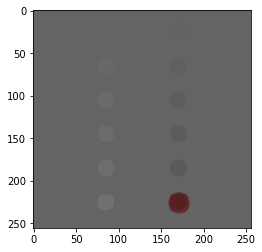

---------------------------
No.1 defect, Semu = 7.801643339472516


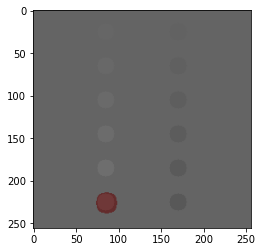

---------------------------
No.2 defect, Semu = 6.501369449560433


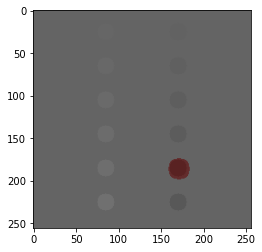

---------------------------
No.3 defect, Semu = 6.501369449560433


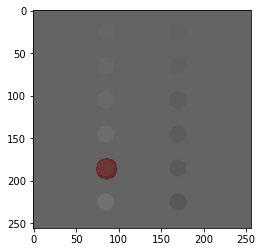

---------------------------
No.4 defect, Semu = 5.201095559648334


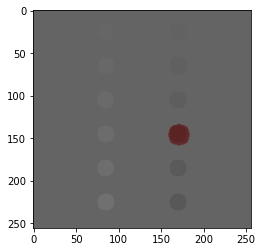

---------------------------
No.5 defect, Semu = 5.201095559648334


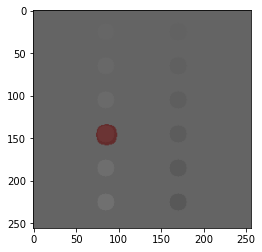

---------------------------
No.6 defect, Semu = 3.900821669736251


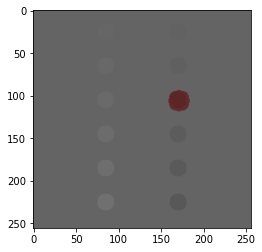

---------------------------
No.7 defect, Semu = 3.900821669736251


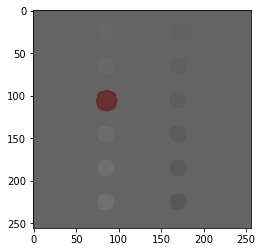

---------------------------
No.8 defect, Semu = 2.600547779824167


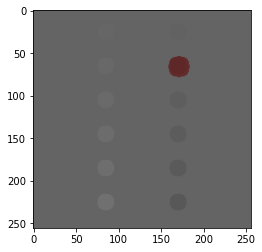

---------------------------
No.9 defect, Semu = 2.6053017654648425


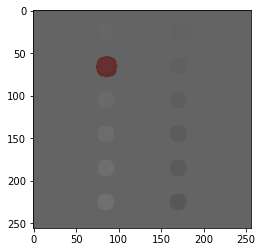

---------------------------
No.10 defect, Semu = 1.4029335325286318


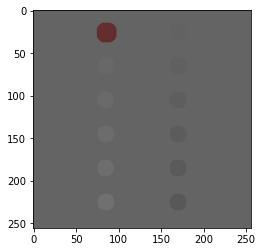

---------------------------
No.11 defect, Semu = 1.3002738899120836


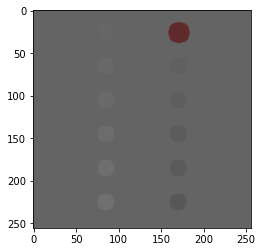

---------------------------
No.12 defect, Semu = 0.22079499396559524


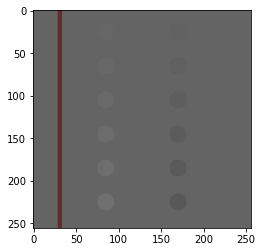

In [224]:
for j in range(len(lst_dfcts)):
    drawing2 = np.zeros((opening.shape[0], opening.shape[1], 3), dtype=np.uint8)
    cv2.drawContours(drawing2, contours, j, color, -1, cv2.LINE_8)
    for i in range(3): # overlay
        drawing2[:,:,i] = drawing2[:,:,i]+img
    
    print("---------------------------\nNo.{} defect, Semu = {}".format(j,Semu_i[j]))
    plt.imshow(drawing2)
    plt.show()

In [207]:
for i in range(len(lst_dfcts)):
    print("defect",i,"","# of pixels:",len(lst_dfcts[i]))
    print("\tbackground intensity:",I_Back[i])

defect 0  # of pixels: 689
	background intensity: 132.91135734072023


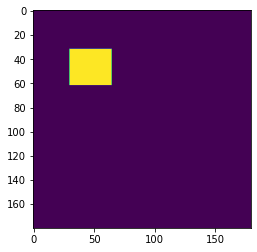

In [208]:
cimg,cimg2 = np.zeros_like(opening), np.zeros_like(opening)
for i in range(len(contours)):
    cv2.drawContours(cimg, contours, i, color, -1, cv2.LINE_8)#, hierarchy, 0)
    # cv2.drawContours(drawing, contours, i, color, -1, cv2.LINE_8, hierarchy, 0)
    pts = np.where(cimg == 255)
    lst_dfcts.append(img[pts[0], pts[1]]) # record the intensity at the defect pixels
    bdRect.append(cv2.boundingRect(contours[i]))
    cv2.rectangle(cimg2, (int(bdRect[i][0]), int(bdRect[i][1])),\
                  (int(bdRect[i][0]+bdRect[i][2]), int(bdRect[i][1]+bdRect[i][3])), 255, -1)
    pts2 = np.where(cimg2 == 255)
    lst_bdbox.append(img[pts2[0], pts2[1]])
    plt.imshow(cimg2)